In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.16.2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


(60000, 28, 28)


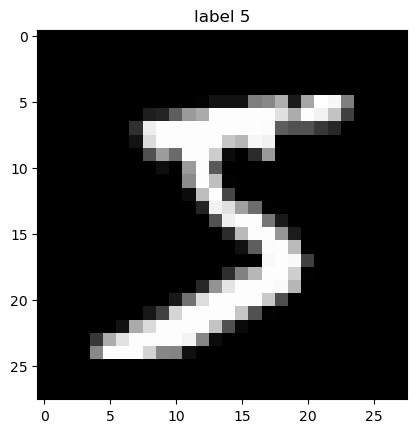

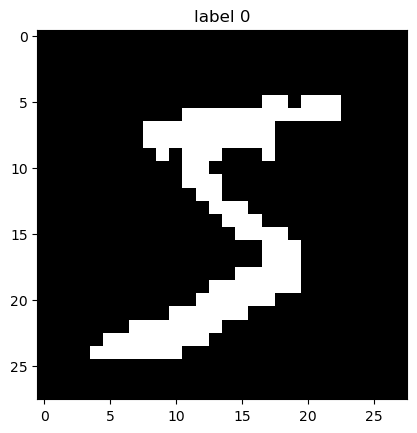

In [2]:

# ============================
#   CARGO Y PREPROCESO MNIST
# ============================
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape)  # (60000, 28, 28)

plt.imshow(x_train[0], cmap='gray')
plt.title("label {}".format(y_train[0]))
plt.show()

# Normalización a [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# === MEJORA RECOMENDADA: BINARIZACIÓN DINÁMICA ===
# Redondeamos: todo lo que sea > 0.5 se vuelve 1.0, lo demás 0.0
# Esto ayuda mucho a la Loss 'Binary Crossentropy'
x_train[x_train >= 0.5] = 1.0
x_train[x_train < 0.5]  = 0.0
x_test[x_test >= 0.5]   = 1.0
x_test[x_test < 0.5]    = 0.0
# =================================================

# Reshape para canales (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

#plot imagen de entrada (28x28)
plt.imshow(x_train[0].squeeze(), cmap='gray')
plt.title("label {}".format(np.argmax(y_train[0])))
plt.show()


In [17]:
latent_dim = 16  # podés probar con 2, 8, 16, etc.

# ==========================================
# 1. DEFINICIÓN DE LA CAPA DE MUESTREO (Reparametrización)
# ==========================================
class Sampling(layers.Layer):
    """Usa (z_mean, z_log_var) para muestrear z, el vector que codifica un dígito."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Generamos ruido aleatorio normal estándar
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        # Fórmula de reparametrización: z = mean + exp(0.5 * log_var) * epsilon
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# ==========================================
# 2. DEFINICIÓN DEL ENCODER (Convolucional)
# ==========================================
encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# Salidas del encoder: media y log-varianza
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Usamos la capa de muestreo
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# ==========================================
# 3. DEFINICIÓN DEL DECODER (Convolucional)
# ==========================================
decoder_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(decoder_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)

# Salida tipo sigmoide para obtener valores entre [0, 1] (píxeles)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(decoder_inputs, decoder_outputs, name="decoder")
decoder.summary()

# ==========================================
# 4. CLASE VAE (Versión Robusta / Estable)
# ==========================================
class VAE(keras.Model):
    def __init__(self, encoder, decoder, use_mse=False, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.use_mse = use_mse 
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        with tf.GradientTape() as tape:
            # 1. Encode
            z_mean, z_log_var, z = self.encoder(data)
            # 2. Decode
            reconstruction = self.decoder(z)
            
            # 3. Calcular Pérdida de Reconstrucción
            if self.use_mse:
                loss_per_pixel = tf.square(data - reconstruction)
            else:
                loss_per_pixel = keras.losses.binary_crossentropy(data, reconstruction)
            
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(loss_per_pixel, axis=(1, 2)))
            
            # === PROTECCIÓN CONTRA EXPLOSIONES ===
            # Recortamos log_var para que esté entre -5 y 5. 
            # Esto evita que exp(z_log_var) devuelva infinito.
            z_log_var = tf.clip_by_value(z_log_var, -5.0, 5.0)
            # =====================================

            # 4. Calcular Pérdida KL (entre N(z_mean, exp(z_log_var)) y N(0,I) -> evita que el espacio latente se descontrole)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss

        # 5. Backpropagation
        grads = tape.gradient(total_loss, self.trainable_weights)
        grads = [tf.clip_by_norm(g, 1.0) for g in grads] # Clip de gradiente (evita que exploten)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 7, 7, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3136)      │          0 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │     50,192 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │        272 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │        272 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 16)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,552 (271.69 KB)

 Trainable params: 69,552 (271.69 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3136)           │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,993 (425.75 KB)

 Trainable params: 108,993 (425.75 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# 5. RE-INSTANCIAR Y COMPILAR 
# ==========================================
tf.keras.backend.clear_session()

vae = VAE(encoder, decoder, use_mse=True) 

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

In [5]:
hist = vae.fit(x_train, epochs=50, batch_size=128)

Epoch 1/50


2025-11-30 12:18:56.006443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - kl_loss: 2.4261 - loss: 97.2003 - reconstruction_loss: 94.7742 
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - kl_loss: 1.8911 - loss: 63.4629 - reconstruction_loss: 61.5718
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - kl_loss: 2.8153 - loss: 58.7256 - reconstruction_loss: 55.9103
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - kl_loss: 3.4023 - loss: 56.3107 - reconstruction_loss: 52.9083
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - kl_loss: 3.6051 - loss: 54.9232 - reconstruction_loss: 51.3181
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - kl_loss: 3.4883 - loss: 53.8237 - reconstruction_loss: 50.3354
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 35ms/step - kl_loss: 3.4445 - loss: 53.0265 - reconstruction_loss: 49.5820
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - kl_loss: 3.3864 - loss: 52.4120 - reconstruction_loss: 49.0255
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - kl

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


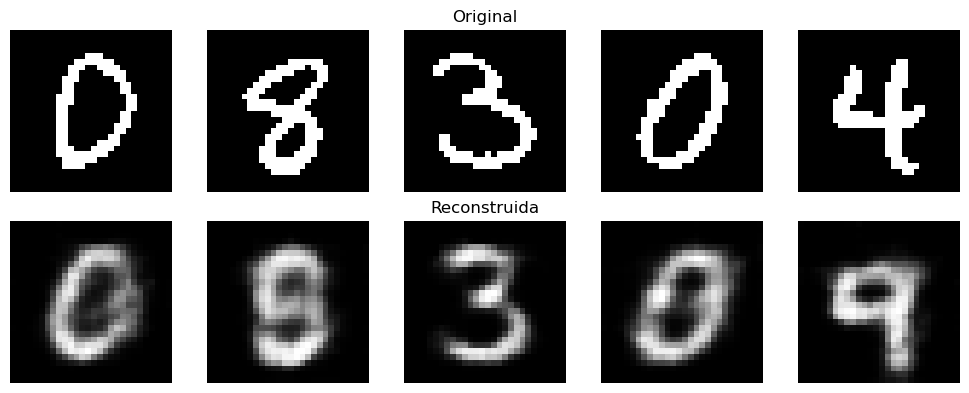

In [11]:
# --- Reconstrucciones sobre test ---
n = 5 # cuántas imágenes mostrar
idxs = np.sort(np.random.choice(len(x_test), size=20, replace=False))
x_test_batch = x_test[idxs]

# Pasamos por el encoder y el decoder
z_mean, z_log_var, z = encoder.predict(x_test_batch)
x_recon = decoder.predict(z)

plt.figure(figsize=(2 * n, 4))

for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_batch[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == n//2:
        ax.set_title("Original")

    # Reconstruida
    ax = plt.subplot(2, n, n + i + 1)
    plt.imshow(x_recon[i].squeeze(), cmap="gray")
    plt.axis("off")
    if i == n//2:
        ax.set_title("Reconstruida")

plt.tight_layout()
plt.show()

Generando mapa del espacio latente (dims 0 y 1)...
Graficando dimensión 3 vs dimensión 10 (de un total de 16)


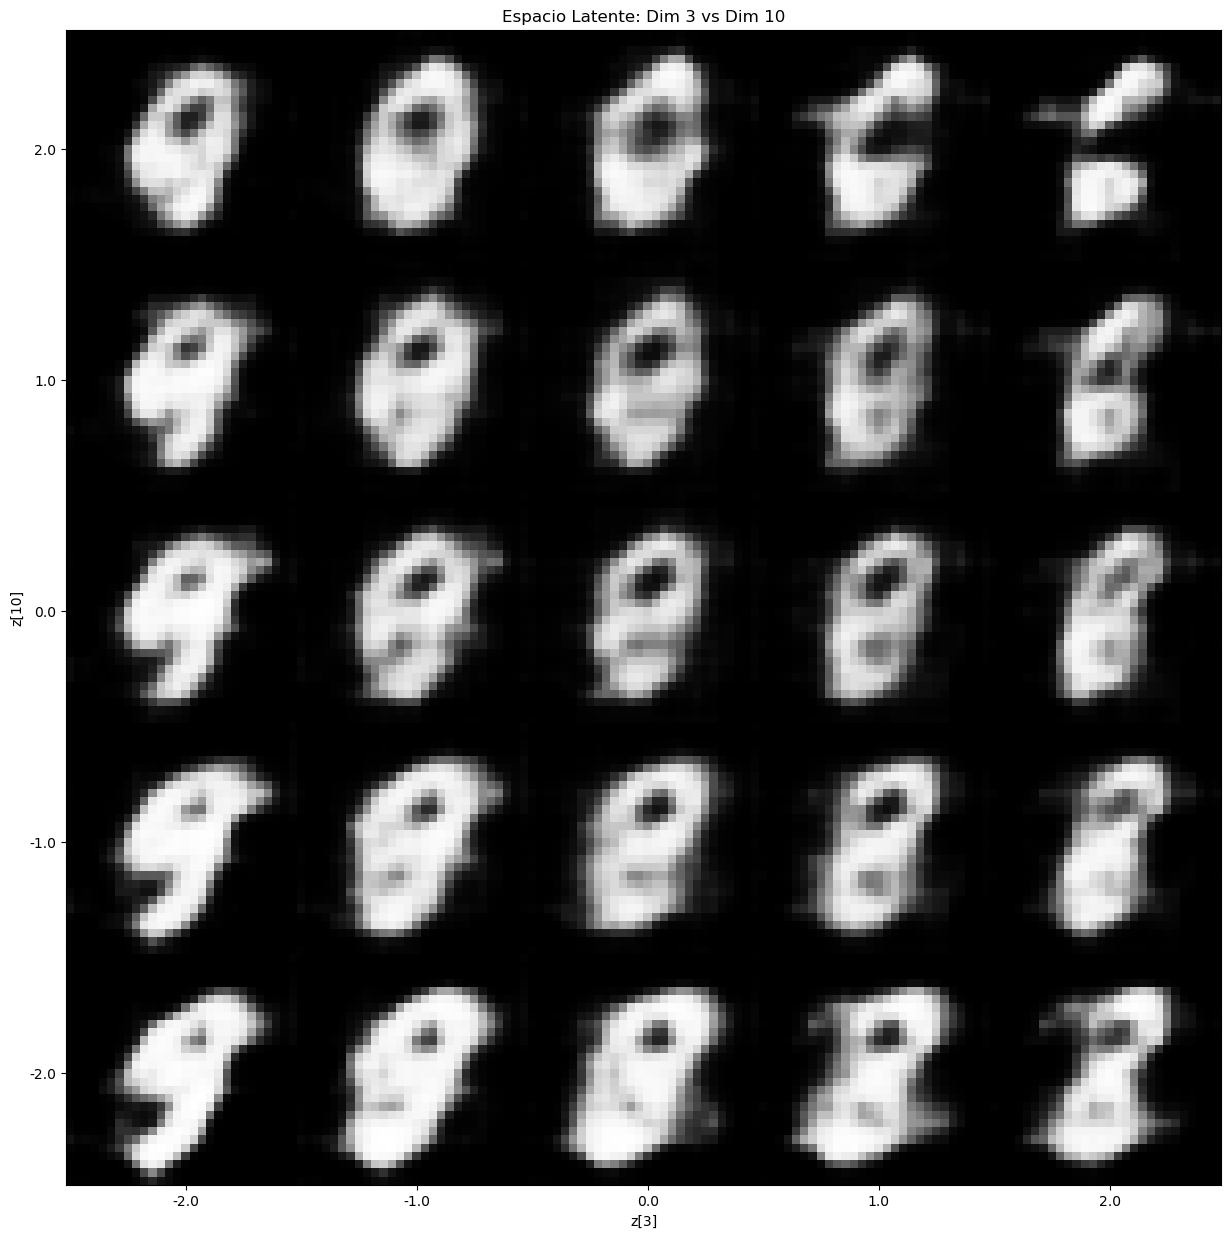

Ejemplo de reconstrucción:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


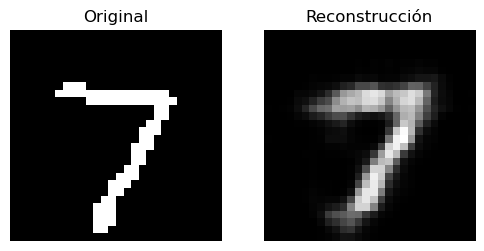

In [ ]:
def plot_latent_space(vae, n=5, figsize=15, dim_x=0, dim_y=1):

    latent_dim = vae.decoder.input_shape[-1]
    
    print(f"Graficando dimensión {dim_x} vs dimensión {dim_y} (de un total de {latent_dim})")
    
    scale = 2.0
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            # 1. Creamos un vector lleno de ceros (el "centro" del espacio)
            z_sample = np.zeros((1, latent_dim))
            
            # 2. Insertamos los valores de barrido en las dimensiones elegidas
            z_sample[0, dim_x] = xi
            z_sample[0, dim_y] = yi
            
            # 3. Predecimos
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel(f"z[{dim_x}]")
    plt.ylabel(f"z[{dim_y}]")
    plt.imshow(figure, cmap="Greys_r")
    plt.title(f"Espacio Latente: Dim {dim_x} vs Dim {dim_y}")
    plt.show()

# ==========================================
# EJECUCIÓN
# ==========================================

plot_latent_space(vae, dim_x=3, dim_y=10)

print("Ejemplo de reconstrucción:")
# Predecimos sobre el primer ejemplo de test
encoded_imgs = vae.encoder.predict(x_test[:1]) 

z_sample = encoded_imgs[2] 

reconstructed_img = vae.decoder.predict(z_sample)

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(x_test[0].squeeze(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Reconstrucción")
plt.imshow(reconstructed_img[0].squeeze(), cmap='gray')
plt.axis('off')
plt.show()

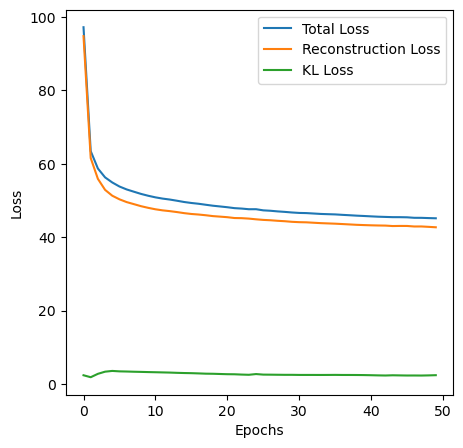

In [19]:
# ==========================================
#plot losses
plt.figure(figsize=(5, 5))
plt.plot(hist.history['loss'], label='Total Loss')
plt.plot(hist.history['reconstruction_loss'], label='Reconstruction Loss')
plt.plot(hist.history['kl_loss'], label='KL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()